# Activations, Gradients and BatchNorm


**References:**
1. [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&ab_channel=AndrejKarpathy)

2. [
Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-12-01 11:45:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.002s  

2022-12-01 11:45:05 (88.7 MB/s) - ‘names.txt’ saved [228145/228145]



## Load data

In [4]:
words = open("names.txt", "r").read().splitlines()

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}

In [6]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
x, y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [8]:
# compute random indices.
m = len(x)

rand_idxs = torch.randperm(m)
# shuffle the data.
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]

## Starting MLP Model

In [9]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
w2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
params = [c, w1, b1, w2, b2]

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 11897


In [10]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(100):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 9.68189525604248


In [11]:
@torch.no_grad() # decorader disables gradient tracking.
def split_loss(split):
    x, y = {
        "train": {x_train, y_train},
        "val": {x_val, y_val},
        "test": {x_test, y_test}
    }[split]

    emb = c[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)

    print(f"Loss ({split}): {loss}")

split_loss("train")
split_loss("val")

Loss (train): 8.861345291137695
Loss (val): 8.709209442138672


## Sampling from the model

In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = c[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cond.
hmaiz.
hmois.
jmti.
hmoioini.
anlay.
myon.
nulan.
yre.
khcafzjty.
keia.
maiie.
ken.
ken.
hmoel.
iucif.
juh.
rosvwuxjrmhtz.
qzolh.
deaelleie.


## Fixing the initial loss

We almost always have an estimate of what loss to expect initially (it depends on the loss function used and the problem setup).



In [13]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
w2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
params = [c, w1, b1, w2, b2]

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 11897


Initialy we expect the probability of each character being 1/27, i.e the negative log likelihood should be -log(1/27) = 3.3.

In [14]:
split_loss("train")

Loss (train): 25.991579055786133


In [15]:
-torch.tensor(1 / 27).log()

tensor(3.2958)

**How to pick the right initial weights ?**

We wan't the logits to be roughly zero, or rouhgly equal (at initialization). Iff the loss is large it is likely that the weights of the network are large, i.e the first $n$ iterations of training will be spend squashing the weights (this may take an order of 10000 iterations), since by squashing them we get a much lower loss. This is why our loss looked like a hocky stick. 

In [16]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0
params = [c, w1, b1, w2, b2]

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 11897


In [17]:
split_loss("train")

Loss (train): 3.3078062534332275


**Train the network using the new intialization**

We can see that the training and validation loss is much better now. 

In [18]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(200000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 2.1009161472320557


[]

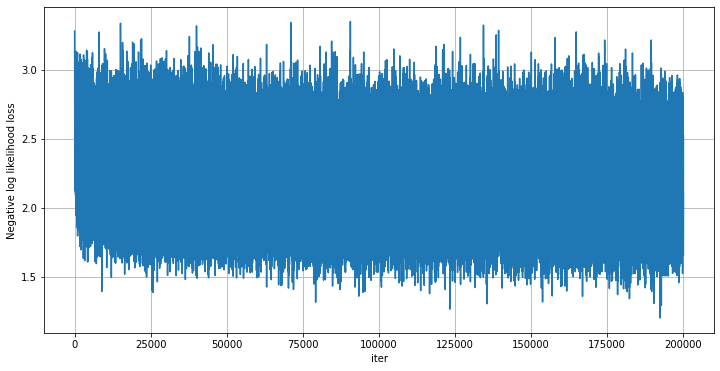

In [19]:
plt.figure(figsize=(12, 6))
plt.xlabel("iter")
plt.ylabel("Negative log likelihood loss")
plt.plot(losses)
plt.grid()
plt.plot()

In [20]:
split_loss("train")
split_loss("val")

Loss (train): 2.1754372119903564
Loss (val): 2.1704049110412598


## Fixing the saturated $\text{tanh}$



<ipython-input-21-afb2c21a27c0>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(-5, 5, 0.01), torch.range(-5, 5, 0.01).tanh());


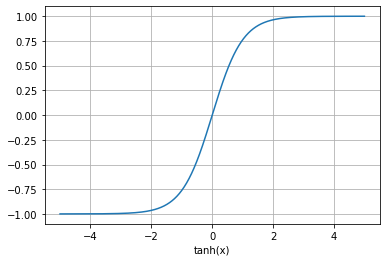

In [21]:
plt.plot(torch.range(-5, 5, 0.01), torch.range(-5, 5, 0.01).tanh());
plt.xlabel("x");
plt.xlabel("tanh(x)");
plt.grid();

**Inspecting tanh activations**

We can see that we have lost of values of tanh which are either 1 or -1. This is not ok !

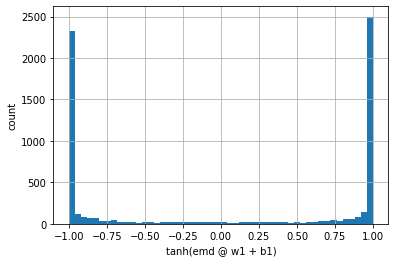

In [22]:
# lets see the tanh activations as a histogram
plt.hist(h.view(-1).tolist(), 50);
plt.xlabel("tanh(emd @ w1 + b1)")
plt.ylabel("count")
plt.grid()

We see that the values which we feed into tanh are too extreme, therefore the tanh is saturared.

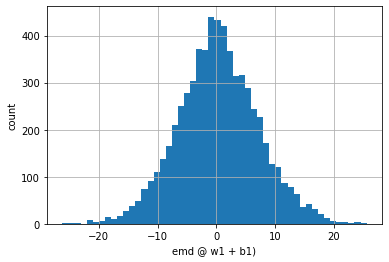

In [23]:
# lets see the tanh activations as a histogram
h_pr = emb.view(-1, w1.shape[0]) @ w1 + b1
plt.hist(h_pr.view(-1).tolist(), 50);
plt.xlabel("emd @ w1 + b1)")
plt.ylabel("count")
plt.grid()

**Why is this a problem ?**

If you recall the implementaion of tanh in micrograd:

```python
def tanh(self):
    x = self.data
    t = (exp(2*x) - 1)/(exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
        self.grad += (1 - t**2) * out.grad
    out._backward = _backward
```

The problem accures when computing the gradient of tanh, which is computed as
follows `self.grad += (1 - t**2) * out.grad`, if t=1 or t=-1 (where t is the value of tanh) than the gradient which we compute is equal to zero: `self.grad += (1 - (-1)**2) * out.grad = (1-1) * out.grad = 0`. This can be expressed intuitively, if you look at the plot of tanh above we see that for values close to 1 and values close to -1, the gradient of function is 0, we say that the gradient has vanished.

**What are dead neurons and how can we find them ?**

The white spaces bellow have a absolute tanh activation greater than 0.99, i.e in all this cases the gradient would vanish. 

A single column in the h matrix is a single neuron. If a single column (i.e a signle neuron) would be all white (i.e all saturateed) we would call it a dead neuron, since no gradient would pass though it.

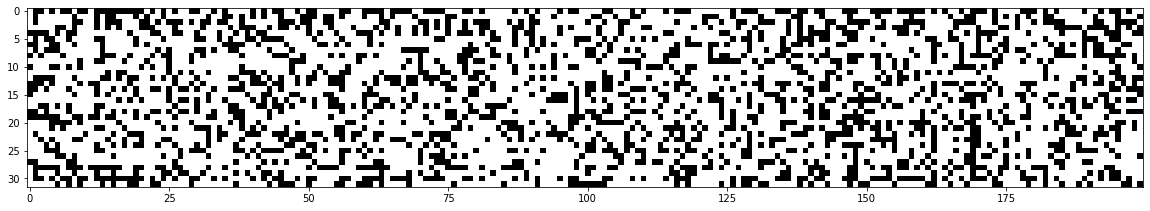

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");

**How can we get dead neurons ?**
1. using a dead-neuron prone activation function (i.e the ReLU function, which has a gradient of zero for ReLU(x) < 0)
2. It can happen at initialization, (i.e if all weights in ReLU by chance are negative, their gradients are 0 therefore they will never learn, i.e get different than zero).
3. Durring traing, if we use a high learning rate, neurons may get kicked into the region which has a gradient of zero, i.e they will be dead for ever !).

**So what activation function to use than**

You can use the leaky ReLU function, which doesn't have a gradient of zero for any value.

<ipython-input-25-3e4fb6e6475c>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  leaky_relu = torch.max(0.1 * torch.range(-5, 5, 0.01), torch.range(-5, 5, 0.01))
<ipython-input-25-3e4fb6e6475c>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(-5, 5, 0.01), leaky_relu)


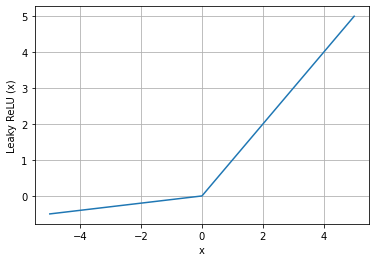

In [25]:
leaky_relu = torch.max(0.1 * torch.range(-5, 5, 0.01), torch.range(-5, 5, 0.01))
plt.plot(torch.range(-5, 5, 0.01), leaky_relu)
plt.xlabel("x")
plt.ylabel("Leaky ReLU (x)")
plt.grid()

**Lets fix the tanh problem**

We will mutlipy the weights $w1$ and $b2$ by a small number. We'll train the network and check if this solves our problem of saturated tanh.

In [26]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0
params = [c, w1, b1, w2, b2]

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 11897


In [27]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(200000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 1.6432017087936401


**How come the results are that much better ?**

We spend a larger potion of the time doing productive training, since tanh is not saturated. 

In [28]:
split_loss("train")
split_loss("val")

Loss (train): 2.1514759063720703
Loss (val): 2.1466288566589355


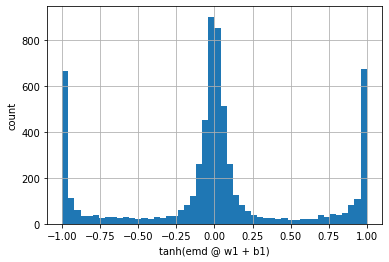

In [29]:
# lets see the tanh activations as a histogram
plt.hist(h.view(-1).tolist(), 50);
plt.xlabel("tanh(emd @ w1 + b1)")
plt.ylabel("count")
plt.grid()

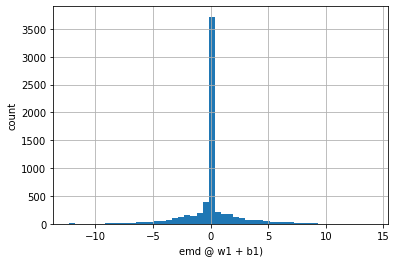

In [30]:
# lets see the tanh activations as a histogram
h_pr = emb.view(-1, w1.shape[0]) @ w1 + b1
plt.hist(h_pr.view(-1).tolist(), 50);
plt.xlabel("emd @ w1 + b1)")
plt.ylabel("count")
plt.grid()

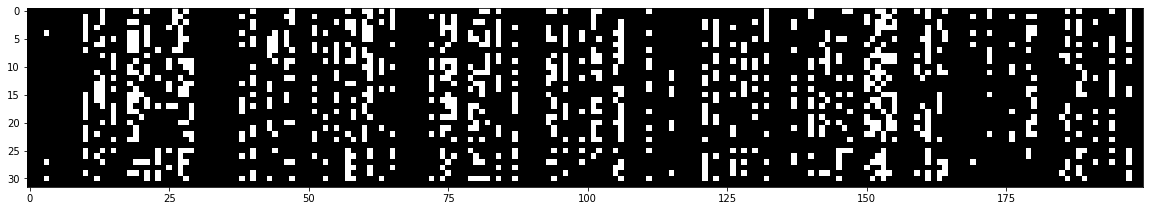

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");

## Kaiming init

On the example bellow we see that how the distribution of values changes between the input tensor x1 and the output tensor y1. We see that the mean stays the same, but the standard deviation increases. **We don't wan't to increase the standard deviation is we perform the forward pass, since this blows up our weights and can lead to saturation of activation functions and then to the vanishing gradinet.**


**How do we preserve the standard deviation between x1 and y1 = x1 @ w1 ?**

We have to normalize the weights by the "varianc", i.e normalize by the $\frac{\text{gain}}{\sqrt{\text{input_dim}}}$. If we don't have any non-linearity we have a gain of 1.

Example:

```
w1 = torch.randn(10, 20) / 10**0.5
```

In the paper they found that if we normalize the weights, we also effectively normalize the gradients.

tensor(0.0040) tensor(0.9907)
tensor(-0.0109) tensor(1.0704)


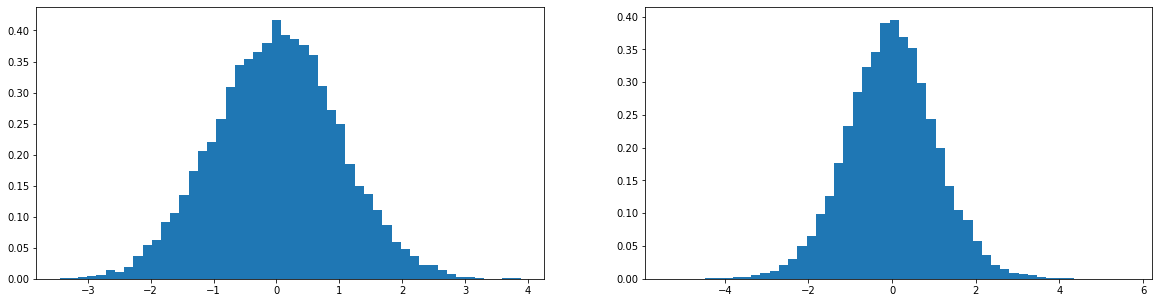

In [32]:
x1 = torch.randn(1000, 10)
w1 = torch.randn(10, 20) / 10**0.5
y1 = x1 @ w1
print(x1.mean(), x1.std())
print(y1.mean(), y1.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x1.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y1.view(-1).tolist(), 50, density=True);

**Initializing our weights using the kaiming approach**

We can find the corresponding gain for each activation function here: https://pytorch.org/docs/stable/nn.init.html. 

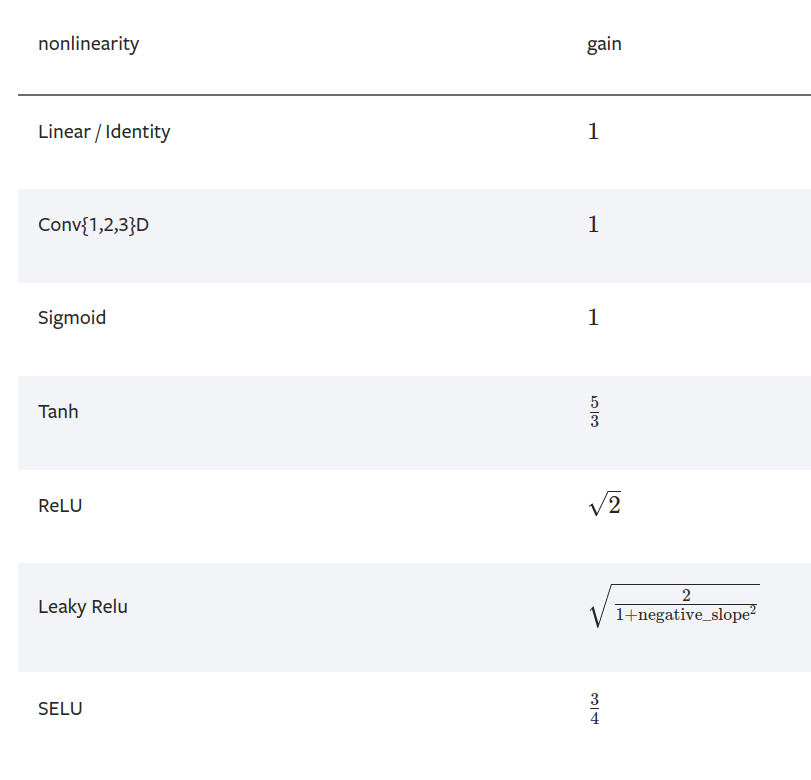

**We are using the tanh activation function so we should multiply by the following factor.**

In [33]:
from math import sqrt
norm_fact = (5 / 3) / sqrt(n_embed * block_size)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * norm_fact

In [34]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5 / 3) / sqrt(n_embed * block_size)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0
params = [c, w1, b1, w2, b2]

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 11897


Lets retrain the network.

In [35]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(200000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 2.0621633529663086


In [36]:
split_loss("train")
split_loss("val")

Loss (train): 2.123971462249756
Loss (val): 2.125809907913208


## Batch Normalization


**Idea of the paper**
In order to get good (i.e not saturated, since this results in a gradient of zero, and not to close to 0 since, than the gradient doesn't do anything, it just passes the out.grad through) activations we want the input values to tanh be gaussian distribution (with zero mean, and unit standard deviation). **So, we just take the hidden stattes and normalize them to be gaussian**.



Lets normalize the **h_pre_act**.



In [37]:
# Forward pass
emb = c[x_batch]
h_pre_act = emb.view(-1, w1.shape[0]) @ w1 + b1

Shape of `h_pre_act` is `(num samples x num neurons)`

In [38]:
h_pre_act.shape

torch.Size([32, 200])

Get the mean and std for each neuron, i.e compute mean and std along the 0th axis.

In [39]:
mean = h_pre_act.mean(0, keepdim=True)
std = h_pre_act.std(0, keepdim=True)

Normalize the `h_pre_act`. Note that mean and standard deviation are nicely differentiable, i.e we can just backpropagate though it.

In [40]:
(h_pre_act - mean) / std 

tensor([[ 2.1964, -0.8310,  0.0619,  ..., -0.0481,  1.4183, -1.5673],
        [-0.0192,  0.3419,  0.7634,  ...,  0.2807, -0.1396,  0.0096],
        [-1.7911,  0.1076, -0.3599,  ...,  0.4243,  0.3060,  1.3784],
        ...,
        [-0.7960, -0.3024,  0.4968,  ...,  0.4778, -0.6240, -0.2276],
        [-0.1444, -1.7049, -0.9221,  ...,  0.4580,  0.9536, -0.3724],
        [ 0.4449,  1.7621, -1.6664,  ...,  1.8923, -1.5977, -0.7859]],
       grad_fn=<DivBackward0>)

**Important add on**

We wan't the preactivations to be gaussian (with mean zero and std of 1) only at initialization, during traing we should allow the neural network to move the distribution around during training. For this reason the paper introduces a scale and shift. 

In [41]:
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

bn_gain * ((h_pre_act - mean) / std) + bn_bias

tensor([[ 2.1964, -0.8310,  0.0619,  ..., -0.0481,  1.4183, -1.5673],
        [-0.0192,  0.3419,  0.7634,  ...,  0.2807, -0.1396,  0.0096],
        [-1.7911,  0.1076, -0.3599,  ...,  0.4243,  0.3060,  1.3784],
        ...,
        [-0.7960, -0.3024,  0.4968,  ...,  0.4778, -0.6240, -0.2276],
        [-0.1444, -1.7049, -0.9221,  ...,  0.4580,  0.9536, -0.3724],
        [ 0.4449,  1.7621, -1.6664,  ...,  1.8923, -1.5977, -0.7859]],
       grad_fn=<AddBackward0>)

At initialization this works as before, but we wan't the neural network to be able to change this values during training, therefore we should allow gradients for this vectors.

In [42]:
bn_gain = torch.ones((1, n_hidden), requires_grad=True)
bn_bias = torch.zeros((1, n_hidden), requires_grad=True)

bn_gain * ((h_pre_act - mean) / std) + bn_bias

tensor([[ 2.1964, -0.8310,  0.0619,  ..., -0.0481,  1.4183, -1.5673],
        [-0.0192,  0.3419,  0.7634,  ...,  0.2807, -0.1396,  0.0096],
        [-1.7911,  0.1076, -0.3599,  ...,  0.4243,  0.3060,  1.3784],
        ...,
        [-0.7960, -0.3024,  0.4968,  ...,  0.4778, -0.6240, -0.2276],
        [-0.1444, -1.7049, -0.9221,  ...,  0.4580,  0.9536, -0.3724],
        [ 0.4449,  1.7621, -1.6664,  ...,  1.8923, -1.5977, -0.7859]],
       grad_fn=<AddBackward0>)

**Putting it all together and training the network**

In [43]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5 / 3) / sqrt(n_embed * block_size)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0

#######################################################
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
params = [c, w1, b1, w2, b2, bn_gain, bn_bias]
#######################################################

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 12297


In [44]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(200000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]

    #######################################################
    h_pre_act = emb.view(-1, w1.shape[0]) @ w1 + b1
    h_mean = h_pre_act.mean(0, keepdim=True)
    h_std = h_pre_act.std(0, keepdim=True)
    h_pre_act = (h_pre_act - h_mean) / h_std
    h = bn_gain * torch.tanh(h_pre_act) + bn_bias
    #######################################################
    
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 2.349536895751953


We also have to add the batch norm to the evaluation pipeline, since the parameters `bn_gain` and `bn_bias` are also learned.

In [45]:
@torch.no_grad() # decorader disables gradient tracking.
def split_loss(split):
    x, y = {
        "train": {x_train, y_train},
        "val": {x_val, y_val},
        "test": {x_test, y_test}
    }[split]

    emb = c[x]
    h_pre_act = emb.view(-1, w1.shape[0]) @ w1 + b1
    h_mean = h_pre_act.mean(0, keepdim=True)
    h_std = h_pre_act.std(0, keepdim=True)
    h_pre_act = (h_pre_act - h_mean) / h_std
    h = bn_gain * torch.tanh(h_pre_act) + bn_bias
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)

    print(f"Loss ({split}): {loss}")

In [46]:
split_loss("train")
split_loss("val")

Loss (train): 2.1278626918792725
Loss (val): 2.1274967193603516


**It turns out that batch normalization is effectively a regularization technique, why is this the case ?**

Note that if we don't use the batch normalization each activation correspond to a single training sample. But since we are now normalizing the activations by computing the mean and std over all samples in the batch (random subset of training data), the activation for a single sample is infuenced by all of the samples in the batch. We can think of this as a data augmentation (i.e we are introducting some entropy to activations), the side effect of batch norm is therefore regularization.

**Calibrating the batch norm at the end of training**

Note that in the evaluation pipeline we we fetch the mean and std of a batch in order to get the network prediction, but what if a single sample is fed to the network ?

For that reason we often compute a global mean and std over the training samples, this is called the "calibaration of the batch norm at the end of training".

In [47]:
with torch.no_grad():
    emb = c[x_train]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ w1 + b1 
    # Measure the mean and std over entire training set
    bn_global_mean = h_pre_act.mean(0, keepdim=True)
    bn_global_std = h_pre_act.std(0, keepdim=True)

In [48]:
@torch.no_grad() # decorader disables gradient tracking.
def split_loss(split):
    x, y = {
        "train": {x_train, y_train},
        "val": {x_val, y_val},
        "test": {x_test, y_test}
    }[split]

    emb = c[x]
    h_pre_act = emb.view(-1, w1.shape[0]) @ w1 + b1
    h_pre_act = (h_pre_act - bn_global_mean) / bn_global_std
    h = bn_gain * torch.tanh(h_pre_act) + bn_bias
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)

    print(f"Loss ({split}): {loss}")

In [49]:
split_loss("train")
split_loss("val")

Loss (train): 2.1278626918792725
Loss (val): 2.127232551574707


**We can also compute the running average of this global mean and std during training**

Doing it this way eliminate the need for explicit calibration, since we are computing th global mean and std during training.

In [50]:
n_embed = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # size of the vocabularity
block_size = 3 # number of characters used to predict the next one.

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embed), generator=g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5 / 3) / sqrt(n_embed * block_size)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
params = [c, w1, b1, w2, b2, bn_gain, bn_bias]

#######################################################
bn_global_mean = torch.zeros((1, n_hidden))
bn_global_std = torch.ones((1, n_hidden))
#######################################################

print(f"num params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True

num params: 12297


In [51]:
learn_rate = 0.1
batch_size = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(200000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (batch_size, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h_pre_act = emb.view(-1, w1.shape[0]) @ w1 + b1
    #######################################################
    h_mean_i = h_pre_act.mean(0, keepdim=True)
    h_std_i = h_pre_act.std(0, keepdim=True)
    
    with torch.no_grad():
        bn_global_mean = 0.999 * bn_global_mean + 0.001 * h_mean_i
        bn_global_std = 0.999 * bn_global_std + 0.001 * h_std_i

    h_pre_act = (h_pre_act - h_mean_i) / h_std_i
    #######################################################
    h = bn_gain * torch.tanh(h_pre_act) + bn_bias
    
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - learn_rate * p.grad

print(f"loss: {loss.item()}")

loss: 1.9875521659851074


In [52]:
split_loss("train")
split_loss("val")

Loss (train): 2.1330809593200684
Loss (val): 2.1308398246765137


**It turns out that we no longer need the bias $b1$**

If we check out the gradient of the $b1$ tensor, we can see that it is practically zero, i.e it has no effect. The $\text{bn_bias}$ is what is responsible for adding the bias term (i.e shifting the distribution of activations), therefore $b1$ is practially useless.

In [53]:
b1.grad.sum()

tensor(-2.1304e-08)

In [54]:
bn_bias.grad.sum()

tensor(0.4508)

## PyTorch-ifying the code

In [87]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Init weights and apply Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** (0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

BatchNorm implemented as in: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

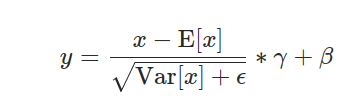

In [224]:
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Init params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Init global params (running average params)
        # called "buffers" in PyTorch
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            # note that this time we are using var = std^2
            x_var = self.running_var 

        # Normalize the pre-activations
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # Update the running mean and var
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [225]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

## Looking at visualizations when we don't have batch normalization

In [205]:
def create_net(weight_gain = 5 / 3):
    n_embed = 10 # the dimensionality of the character embedding vectors
    n_hidden = 100 # the number of neurons in the hidden layer of the MLP
    vocab_size = 27

    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    c = torch.randn((vocab_size, n_embed), generator=g)
    
    layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
    ]

    with torch.no_grad():
        layers[-1].weight *= 0.1
        for layer in layers[: -1]:
            if isinstance(layer, Linear):
                layer.weight *= weight_gain

    params = [c] + [p for layer in layers for p in layer.parameters()]
    print(f"num params: {sum(p.nelement() for p in params)}")
    for p in params:
        p.requires_grad = True

    return c, layers, params

**Training the deeep network**

In [183]:
def train_net(c, layer, params):
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    lossi = []
    ud = []

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

        # forward pass
        emb = c[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in params:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in params:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

        break

**Distribution of tanh activations**

We see that if we use the gain of $5 / 3$ than only the first layer is saturated, saturation percentage tends to converge as the number of layers increases. In this case a value of $5 / 3$ provides nice saturation.

If we use gain of $1$ the activations tend to squash as the number of layers increases, this is because we apply the tanh function which performs the squasing of all real number between -1 and 1, than again a tanh which squashes -1 and 1 into smaller numbers...

If we use gain of $5$ we get too much saturations!

It turns out that $5 / 3$ is a good value used for kaiming intialization (pytorch also uses this number).

In [184]:
def plot_tanh_activations(layers, weight_gain):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act = layer.out
            sat_perc = ((tanh_act.abs() > 0.97).float().mean() * 100.0).item()
            layer_name = layer.__class__.__name__
            tanh_act_mean = tanh_act.mean().item()
            tanh_act_std = tanh_act.std().item()
            print(f"weight_gain: {round(weight_gain, 3)} \t layer: {layer_name} \t mean: {round(tanh_act_mean, 3)}\t std: {round(tanh_act_std, 3)} \t sat_perc[%]: {round(sat_perc, 3)}")
            cnts, vals = torch.histogram(tanh_act, density=True)
            
            # note: `.detach()` returns a new Tensor, detached from the current graph.
            # which will never require gradient.
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title(f'activation distribution, using gain: {round(weight_gain, 3)}');
    plt.plot();

num params: 46497
      0/ 200000: 3.3003
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.047	 std: 0.624 	 sat_perc[%]: 4.688
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.015	 std: 0.492 	 sat_perc[%]: 0.125
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.012	 std: 0.412 	 sat_perc[%]: 0.0
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.016	 std: 0.352 	 sat_perc[%]: 0.0
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.018	 std: 0.323 	 sat_perc[%]: 0.0


num params: 46497
      0/ 200000: 3.3084
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.029	 std: 0.744 	 sat_perc[%]: 19.406
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.005	 std: 0.682 	 sat_perc[%]: 8.812
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.02	 std: 0.656 	 sat_perc[%]: 6.625
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.648 	 sat_perc[%]: 5.156
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.036	 std: 0.653 	 sat_perc[%]: 5.844


num params: 46497
      0/ 200000: 3.3343
weight_gain: 5 	 layer: Tanh 	 mean: 0.001	 std: 0.922 	 sat_perc[%]: 67.906
weight_

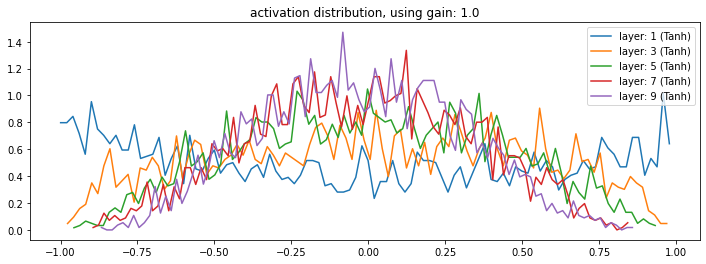

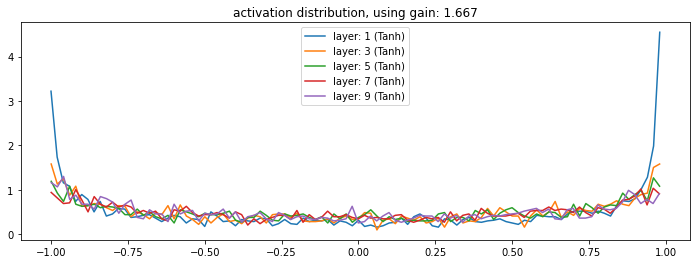

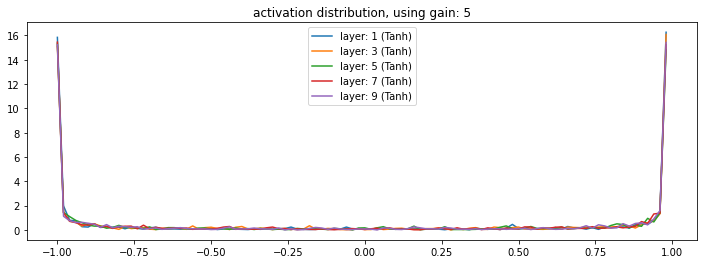

In [185]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_activations(layers, weight_gain)
    print("\n")

**Distribution of gradients**

What do we wan't to see when we look at gradient distribution at different depth of the network ?

We wan't the distribution to be roughly equal at all depths. We also see that if we have a huge gain (e.g $5$) we get distribution which is close to zero (especially at high depth), this is beacuse the network is saturating. 

In [186]:
def plot_tanh_grads(layers, weight_gain):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act_grad = layer.out.grad
            layer_name = layer.__class__.__name__
            tanh_act_mean = tanh_act_grad.mean().item()
            tanh_act_std = tanh_act_grad.std().item()
            print(f"weight_gain: {round(weight_gain, 3)} \t layer: {layer_name} \t mean: {round(tanh_act_mean, 6)}\t std: {round(tanh_act_std, 6)} \t")
            cnts, vals = torch.histogram(tanh_act_grad, density=True)
            
            # note: `.detach()` returns a new Tensor, detached from the current graph.
            # which will never require gradient.
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title(f'gradient distribution, using gain: {round(weight_gain, 3)}');
    plt.plot();

num params: 46497
      0/ 200000: 3.3086
weight_gain: 1.0 	 layer: Tanh 	 mean: -3e-06	 std: 0.000179 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -8e-06	 std: 0.000216 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 1.2e-05	 std: 0.000243 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 4e-06	 std: 0.000276 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 6e-06	 std: 0.000304 	


num params: 46497
      0/ 200000: 3.3101
weight_gain: 1.667 	 layer: Tanh 	 mean: -7e-06	 std: 0.0004 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -6e-06	 std: 0.000379 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -3e-06	 std: 0.000359 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -6e-06	 std: 0.000334 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 6e-06	 std: 0.000303 	


num params: 46497
      0/ 200000: 3.3014
weight_gain: 5 	 layer: Tanh 	 mean: 1.1e-05	 std: 0.002637 	
weight_gain: 5 	 layer: Tanh 	 mean: -1e-05	 std: 0.001656 	
weight_gain: 5 	 layer: Tanh 	 mean: -1e-06	 std: 0.000949 	
weight_gain: 5 	 layer: Tanh 	 mean: 7e-06	 std: 0

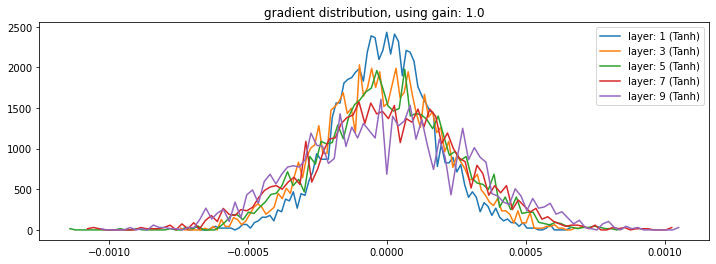

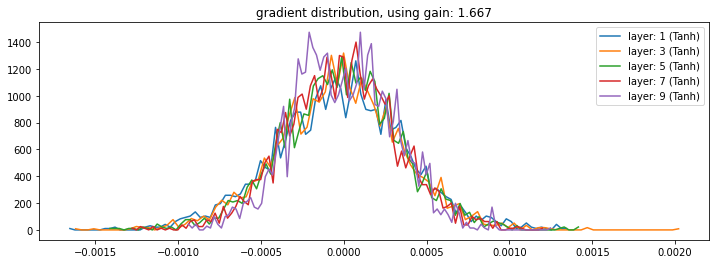

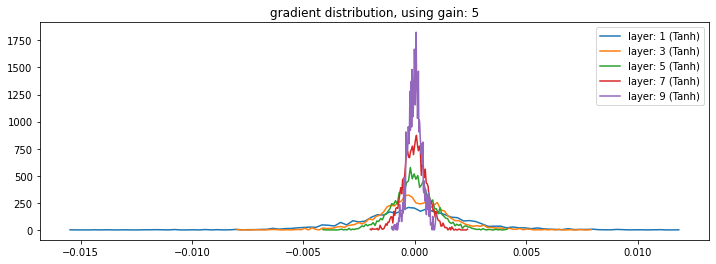

In [187]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_grads(layers, weight_gain)
    print("\n")

**Grad vs data ratio**

grad:data ratio tells us what is the scale of the gradient vs the scale of the parameters. If grad:data is large we risk getting pushed out of trajectory. This is where using a modern optimiser such as Adam comes to the rescue.

In [188]:
def plot_weight_grads(params, weight_gain):
    # visualize histograms
    plt.figure(figsize=(12, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(params):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s \t mean %+f \t std %e \t grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    
    plt.legend(legends);
    plt.title(f'weights gradient distribution, using gain: {round(weight_gain, 3)}');
    plt.plot();

num params: 46497
      0/ 200000: 3.3026
weight   (27, 10) 	 mean -0.000063 	 std 3.758009e-04 	 grad:data ratio 3.755292e-04
weight  (30, 100) 	 mean +0.000008 	 std 7.164443e-04 	 grad:data ratio 3.988508e-03
weight (100, 100) 	 mean +0.000004 	 std 6.509570e-04 	 grad:data ratio 6.504480e-03
weight (100, 100) 	 mean -0.000014 	 std 6.390832e-04 	 grad:data ratio 6.353098e-03
weight (100, 100) 	 mean -0.000006 	 std 6.114372e-04 	 grad:data ratio 6.022216e-03
weight (100, 100) 	 mean +0.000006 	 std 6.742146e-04 	 grad:data ratio 6.700672e-03
weight  (100, 27) 	 mean +0.000000 	 std 1.242554e-02 	 grad:data ratio 1.237819e+00


num params: 46497
      0/ 200000: 3.3110
weight   (27, 10) 	 mean -0.000049 	 std 1.271735e-03 	 grad:data ratio 1.270816e-03
weight  (30, 100) 	 mean +0.000010 	 std 1.292990e-03 	 grad:data ratio 4.266669e-03
weight (100, 100) 	 mean -0.000011 	 std 1.065989e-03 	 grad:data ratio 6.415039e-03
weight (100, 100) 	 mean +0.000013 	 std 9.753778e-04 	 grad:dat

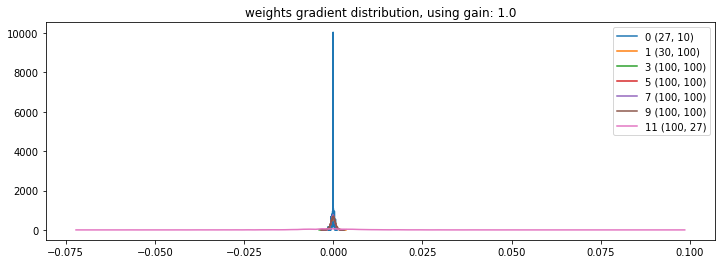

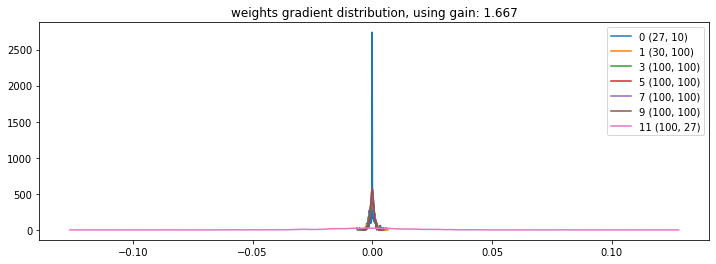

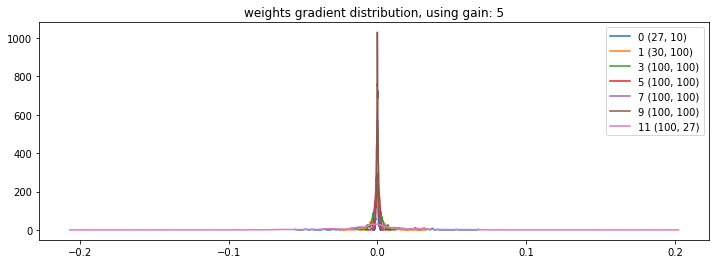

In [189]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_weight_grads(params, weight_gain)
    print("\n")

**Grad.update vs data**

Lets take a look at the grad update vs the data (weights). We see that the updates tend to stabilize over time. If the update curves are bellow the -3 line (in log plot), this means that the network is not learning fast enough, this again confirms that the gain of %5 / 3% is a good choice. 

In [197]:
def train_net(c, layer, params):
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    lossi = []
    ud = []

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

        # forward pass
        emb = c[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in params:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in params:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

        if i >= 1000:
            break # AFTER_DEBUG: would take out obviously to run full optimization

    return ud

num params: 46497
      0/ 200000: 3.3071


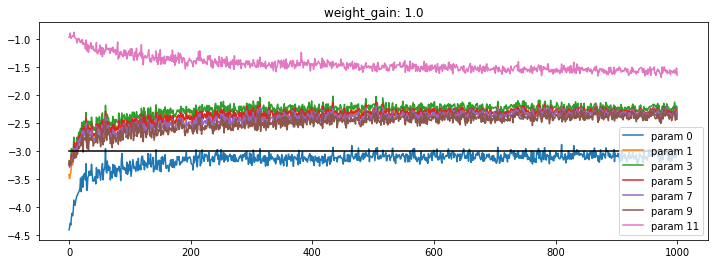



num params: 46497
      0/ 200000: 3.2981


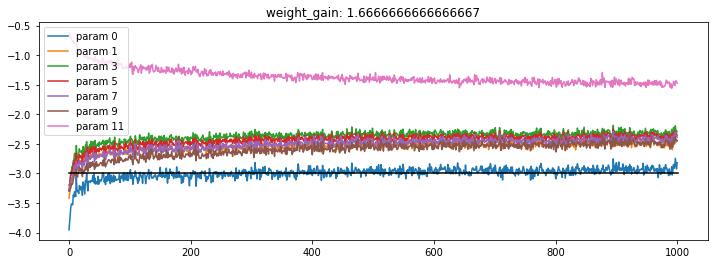



num params: 46497
      0/ 200000: 3.2963


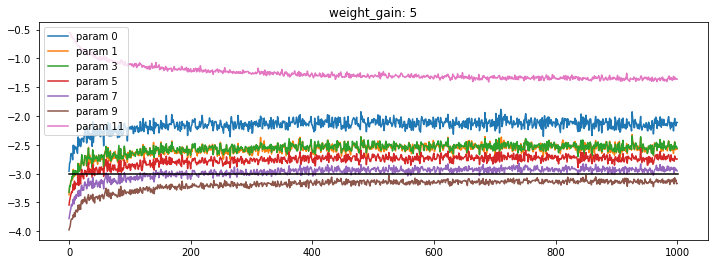

In [199]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    ud = train_net(c, layers, params)
    plt.figure(figsize=(12, 4))
    legends = []
    for i,p in enumerate(params):
        # compute only for weights (ndim == 2)
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)

    # NOTE: these ratios should be ~1e-3, indicate on plot
    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends);
    plt.title(f"weight_gain: {weight_gain}")
    plt.show()
    print("\n")

## Lets run all plots using simple random initialization

In [202]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Init weights and apply Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out), generator=g) # remove this: / fan_in ** (0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

In [203]:
weight_gain = 5 / 3

**We see that the tanh activations are now saturated**

num params: 46497
      0/ 200000: 3.4764
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.034	 std: 0.993 	 sat_perc[%]: 96.906
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.048	 std: 0.979 	 sat_perc[%]: 91.469
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.057	 std: 0.975 	 sat_perc[%]: 90.5
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.011	 std: 0.972 	 sat_perc[%]: 89.094
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.01	 std: 0.973 	 sat_perc[%]: 88.75


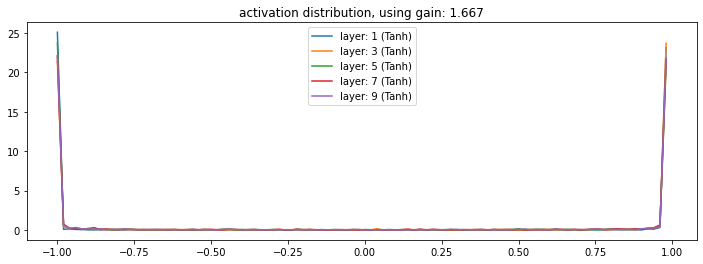

In [206]:
c, layers, params = create_net(weight_gain)
train_net(c, layers, params)
plot_tanh_activations(layers, weight_gain)

**We see that the gradient distribution is now around zero (vanishing gradient)**

num params: 46497
      0/ 200000: 3.7528
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.002754	 std: 0.130554 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.001155	 std: 0.035559 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.000166	 std: 0.012958 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 4.1e-05	 std: 0.004738 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -7.4e-05	 std: 0.001678 	




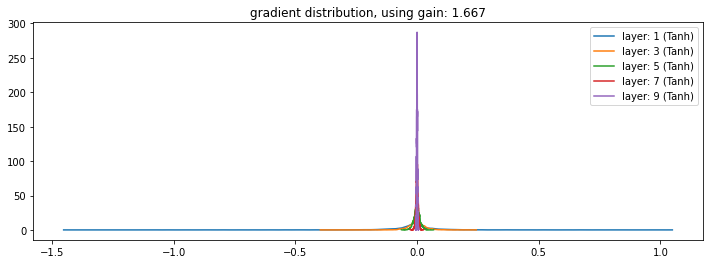

In [207]:
c, layers, params = create_net(weight_gain)
train_net(c, layers, params)
plot_tanh_grads(layers, weight_gain)
print("\n")

**We see that the networks learns too slowly**

We see that some layers are learning super fast, whereas some layers are learning super slow.

num params: 46497
      0/ 200000: 3.8269


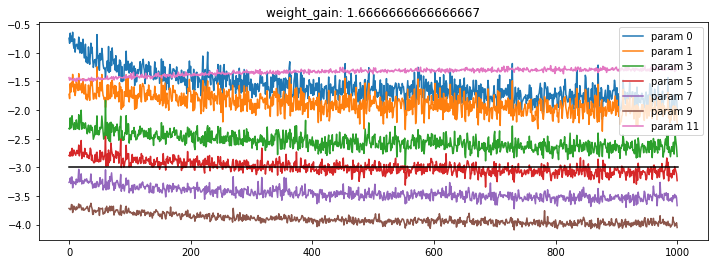

In [209]:
c, layers, params = create_net(weight_gain)
ud = train_net(c, layers, params)
plt.figure(figsize=(12, 4))
legends = []
for i,p in enumerate(params):
    # compute only for weights (ndim == 2)
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
# NOTE: these ratios should be ~1e-3, indicate on plot
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);
plt.title(f"weight_gain: {weight_gain}")
plt.show()
print("\n")

## Looking at visualizations using batch normalization

If we now tweak the gain we sh

In [250]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Init weights and apply Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out), generator=g) * fan_in ** (0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

In [251]:
def create_net(weight_gain = 5 / 3):
    n_embed = 10 # the dimensionality of the character embedding vectors
    n_hidden = 100 # the number of neurons in the hidden layer of the MLP
    vocab_size = 27

    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    c = torch.randn((vocab_size, n_embed), generator=g)
    
    # Place batch norm after linear layer and before nonlinearity.
    layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
    ]

    with torch.no_grad():
        # last layer: make less confident
        layers[-1].gamma *= 0.1
        #layers[-1].weight *= 0.1
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1.0 #5/3

    params = [c] + [p for layer in layers for p in layer.parameters()]
    print(f"num params: {sum(p.nelement() for p in params)}")
    for p in params:
        p.requires_grad = True

    return c, layers, params

In [252]:
def train_net(c, layer, params):
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    lossi = []
    ud = []

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

        # forward pass
        emb = c[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in params:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in params:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

        if i >= 1000:
            break # AFTER_DEBUG: would take out obviously to run full optimization

    return ud

**We see that the tanh activations are now NOT saturated**

We see that tanh activations don't get saturated even if we tweek the gain !!

num params: 47024
      0/ 200000: 3.3059
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.002	 std: 0.631 	 sat_perc[%]: 3.031
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.631 	 sat_perc[%]: 3.062
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.006	 std: 0.633 	 sat_perc[%]: 2.719
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.002	 std: 0.636 	 sat_perc[%]: 2.844
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.004	 std: 0.64 	 sat_perc[%]: 2.438


num params: 47024
      0/ 200000: 3.2847
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.005	 std: 0.63 	 sat_perc[%]: 3.562
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.631 	 sat_perc[%]: 3.25
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.008	 std: 0.636 	 sat_perc[%]: 2.5
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.006	 std: 0.636 	 sat_perc[%]: 2.719
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.003	 std: 0.638 	 sat_perc[%]: 2.75


num params: 47024
      0/ 200000: 3.3288
weight_gain: 5 	 layer: Tanh 	 mean: -0.002	 std: 0.625 	 sat_perc[%]: 3.469
weight_ga

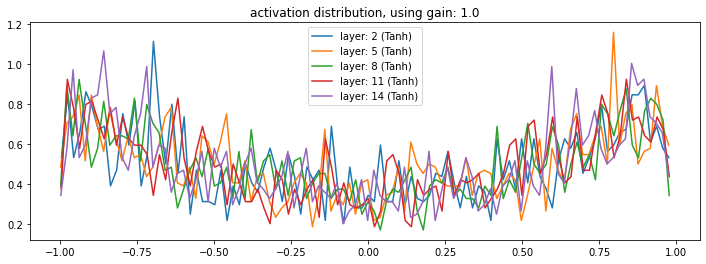

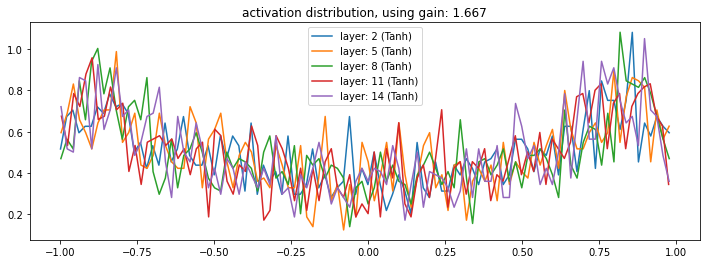

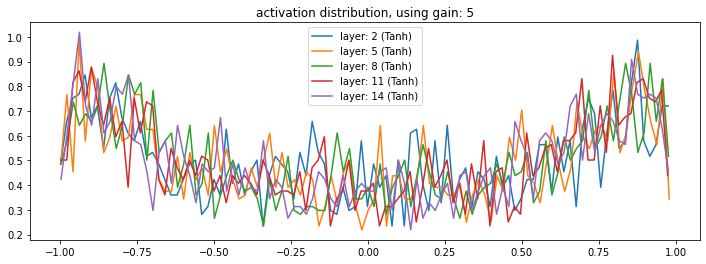

In [253]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_activations(layers, weight_gain)
    print("\n")

**We see that the gradient distribution is now OK**

We see that the tanh gradients tend to stay roughly the same even if we tweek the gain !!


num params: 47024
      0/ 200000: 3.2881
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.002732 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.0	 std: 0.002262 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.001948 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.0	 std: 0.001716 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.0	 std: 0.001438 	


num params: 47024
      0/ 200000: 3.3008
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.002322 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.0	 std: 0.001939 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.001658 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.001446 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.0	 std: 0.001316 	


num params: 47024
      0/ 200000: 3.3112
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.001868 	
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.001682 	
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.00159 	
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.001449 	
weight_gain: 5 	 lay

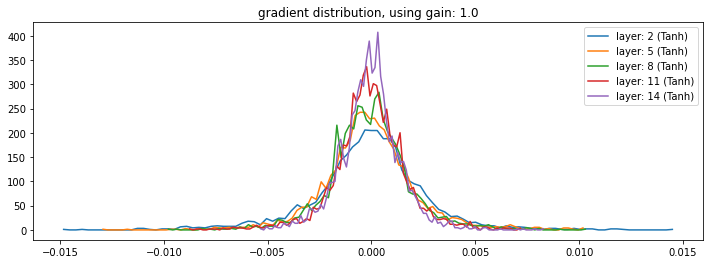

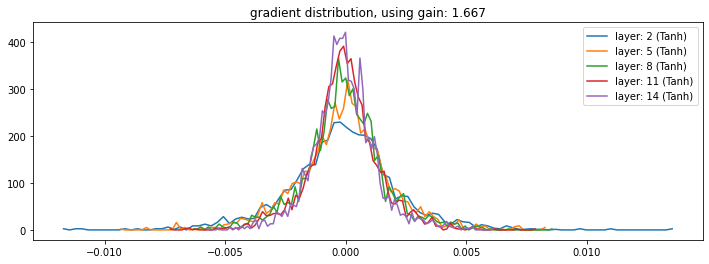

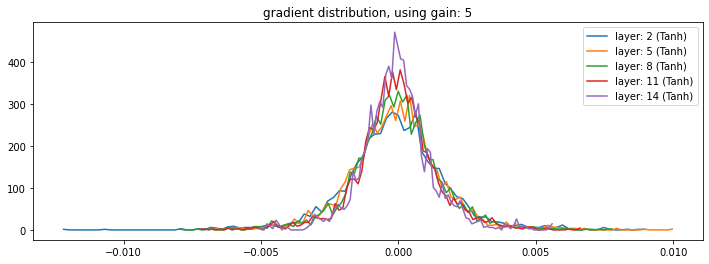

In [254]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_grads(layers, weight_gain)
    print("\n")

**We see that the networks learns too slowly**

The grater the gain, the smaller the grad. updates, i.e if we tweak gain we should make sure that the learning rate is ok.

In all plots bellow we are under the recomended update rate of -3.0, so we should bump up our learning rate.

num params: 47024
      0/ 200000: 3.2810


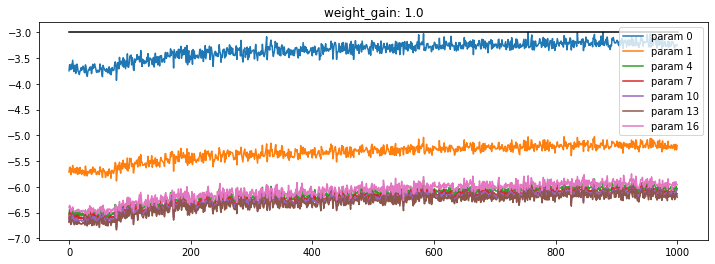



num params: 47024
      0/ 200000: 3.2912


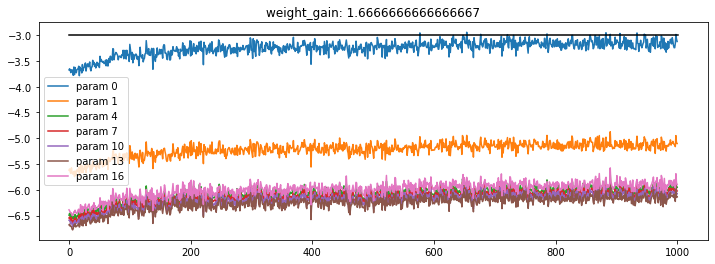



num params: 47024
      0/ 200000: 3.3039


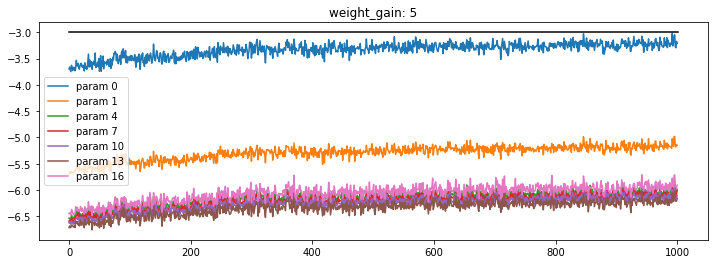

In [256]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    ud = train_net(c, layers, params)
    plt.figure(figsize=(12, 4))
    legends = []
    for i,p in enumerate(params):
        # compute only for weights (ndim == 2)
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)

    # NOTE: these ratios should be ~1e-3, indicate on plot
    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends);
    plt.title(f"weight_gain: {weight_gain}")
    plt.show()
    print("\n")

**Multiplying the learning rate by 10**

In [258]:
def train_net(c, layer, params):
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    lossi = []
    ud = []

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

        # forward pass
        emb = c[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in params:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 * 10 if i < 150000 else 0.01 # step learning rate decay
        for p in params:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

        if i >= 1000:
            break # AFTER_DEBUG: would take out obviously to run full optimization

    return ud

**Activation distribution**

num params: 47024
      0/ 200000: 3.2953
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.035	 std: 0.61 	 sat_perc[%]: 3.438
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.031	 std: 0.608 	 sat_perc[%]: 4.312
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.013	 std: 0.61 	 sat_perc[%]: 4.031
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.033	 std: 0.62 	 sat_perc[%]: 3.344
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.023	 std: 0.616 	 sat_perc[%]: 3.594


num params: 47024
      0/ 200000: 3.2778
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.039	 std: 0.607 	 sat_perc[%]: 4.875
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.017	 std: 0.609 	 sat_perc[%]: 3.781
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.015	 std: 0.615 	 sat_perc[%]: 3.594
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.001	 std: 0.595 	 sat_perc[%]: 3.812
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.018	 std: 0.612 	 sat_perc[%]: 4.219


num params: 47024
      0/ 200000: 3.2988
weight_gain: 5 	 layer: Tanh 	 mean: 0.018	 std: 0.628 	 sat_perc[%]: 3.531
we

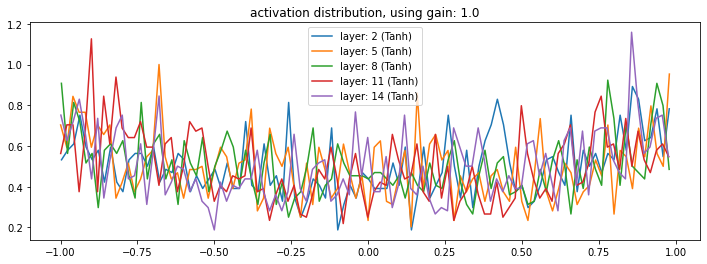

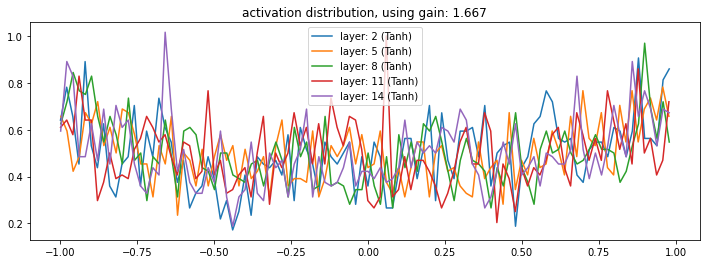

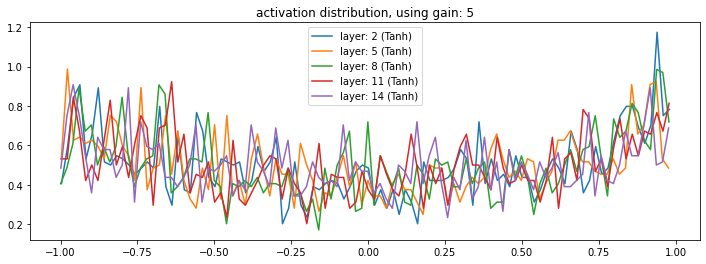

In [259]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_activations(layers, weight_gain)
    print("\n")

**Gradient distribution**

num params: 47024
      0/ 200000: 3.3147
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.005901 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.0	 std: 0.004863 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.004317 	
weight_gain: 1.0 	 layer: Tanh 	 mean: 0.0	 std: 0.004103 	
weight_gain: 1.0 	 layer: Tanh 	 mean: -0.0	 std: 0.003683 	


num params: 47024
      0/ 200000: 3.3043
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.0	 std: 0.004775 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.0	 std: 0.004372 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.004066 	
weight_gain: 1.667 	 layer: Tanh 	 mean: -0.0	 std: 0.003905 	
weight_gain: 1.667 	 layer: Tanh 	 mean: 0.0	 std: 0.003644 	


num params: 47024
      0/ 200000: 3.3040
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.00533 	
weight_gain: 5 	 layer: Tanh 	 mean: 0.0	 std: 0.004775 	
weight_gain: 5 	 layer: Tanh 	 mean: 0.0	 std: 0.004202 	
weight_gain: 5 	 layer: Tanh 	 mean: -0.0	 std: 0.004283 	
weight_gain: 5 	 layer

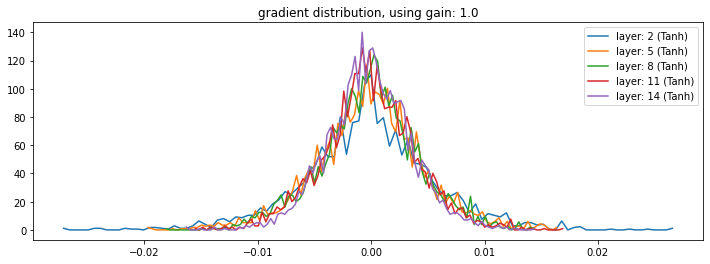

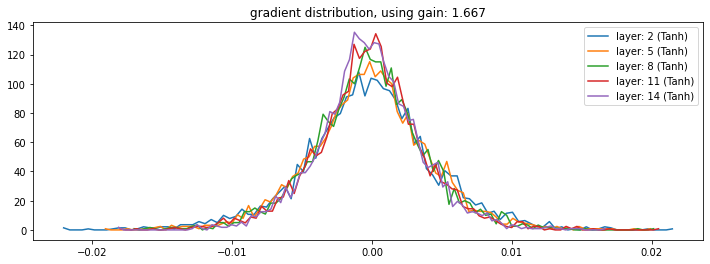

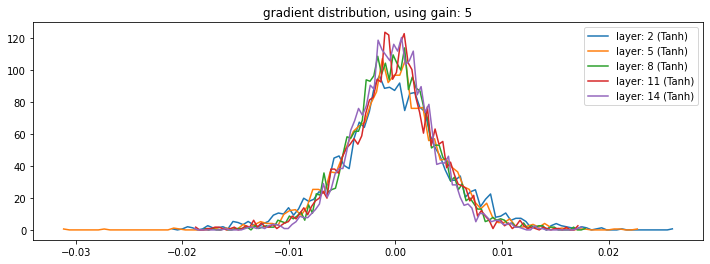

In [260]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    train_net(c, layers, params)
    plot_tanh_grads(layers, weight_gain)
    print("\n")

**Update rate**

num params: 47024
      0/ 200000: 3.3259


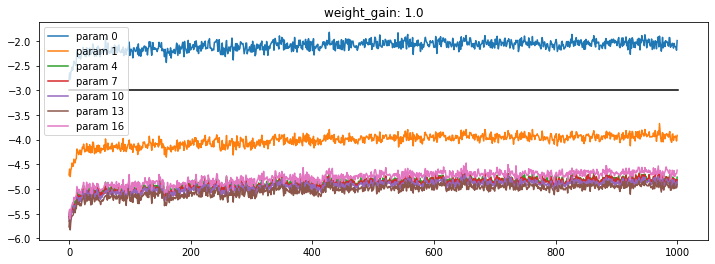



num params: 47024
      0/ 200000: 3.3197


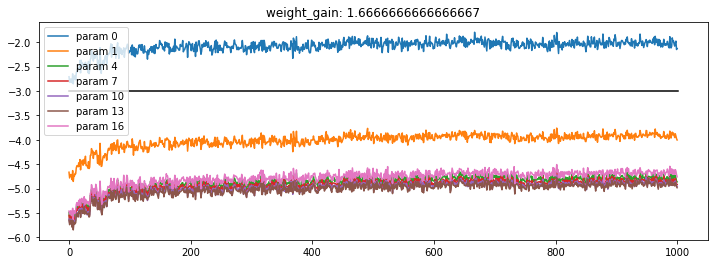



num params: 47024
      0/ 200000: 3.3208


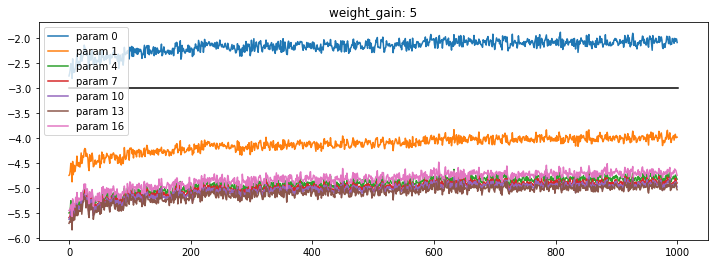

In [261]:
for weight_gain in [1.0, 5 / 3, 5]: 
    c, layers, params = create_net(weight_gain)
    ud = train_net(c, layers, params)
    plt.figure(figsize=(12, 4))
    legends = []
    for i,p in enumerate(params):
        # compute only for weights (ndim == 2)
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)

    # NOTE: these ratios should be ~1e-3, indicate on plot
    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends);
    plt.title(f"weight_gain: {weight_gain}")
    plt.show()
    print("\n")